## Interpreting what convnets learn

### Visualizing intermediate activations

In [ ]:
# load the file "convnet_from_scratch_with_augmentation.keras"
from google.colab import files
files.upload()

In [ ]:
from tensorflow import keras
model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                           

**Preprocessing a single image**

In [ ]:
from tensorflow import keras
import numpy as np

# download a test image
img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    # open the file and resize it
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    # turn the image into a float32 Numpy array of shape(180, 180, 3)
    array = keras.utils.img_to_array(img)
    # Add a dimension to transform the array into a “batch” of a single sample. Its shape is now (1, 180, 180, 3)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

80329/80329 [==============================] - 0s 2us/step


**Displaying the test picture**

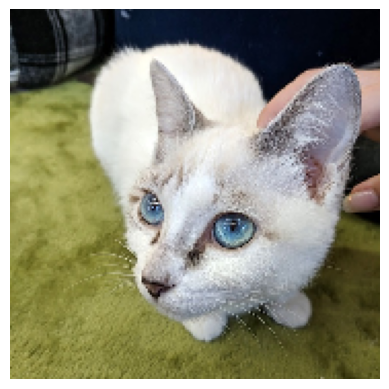

In [ ]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

**Instantiating a model that returns layer activations**

In order to extract the feature maps we want to look at, we’ll create a Keras model that takes batches of images as input, and that outputs the activations of all convolution and pooling layers

**For layer in model.layers explain:**

The code is used to get the output of each layer in a Keras model.
* It first initializes two empty lists, **layer_output**s and **layer_names**.
* Then, it loops through each layer in the model and checks if the layer is an instance of either **layers.Conv2D** or **layers.MaxPooling2D**.
* If the layer is an instance of either of these two types, the output of the layer is appended to the **layer_outputs** list and the name of the layer is appended to the **layer_names** list.
* The **layer_outputs** list will contain the output of each layer that is either a convolutional or max pooling layer, while the **layer_names** list will contain the name of each of these layers.

This code is useful for visualizing the output of intermediate layers in a neural network, which can help in understanding how the network is making its predictions. By examining the output of each layer, we can see how the input is transformed as it passes through the network.

The **isinstance()** function is used to check if a layer is an instance of a particular class. In this case, it is used to check if a layer is either a Conv2D or MaxPooling2D layer. If the layer is an instance of either of these two classes, its output is appended to the layer_outputs list.

In [ ]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    # Extract the outputs of all Conv2D and MaxPooling2D layers and put them in a list.
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
# Create a model that will return these outputs, given the model input
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

**Using the model to compute layer activations**

In [ ]:
# Return a list of nine NumPy arrays: one array per layer activation
# img_tensor is defined above
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 2s 2s/step


In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)
# 178 × 178 feature map with 32 channels

(1, 178, 178, 32)


**Visualizing the fifth channel**

In Python, the slicing [0, :, :, 7] is used to extract elements from a multidimensional array or a list.

Each part of the slicing corresponds to a specific dimension. In this case, the slicing can be interpreted as follows:
* The first part, 0, selects the element at index 0 in the first dimension.
* The colon : is used to select all elements in the second dimension.
* Another colon : is used to select all elements in the third dimension.
* The last part, 7, selects the element at index 7 in the fourth dimension

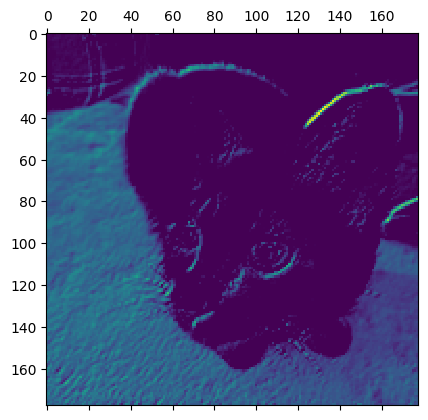

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 7], cmap="viridis")

**Visualizing every channel in every intermediate activation**

Plot a complete visualization of all the activations in the network

Extract and Plot every channel in each of the layer activations, and Stack the results in one big grid, with channels stacked side by side

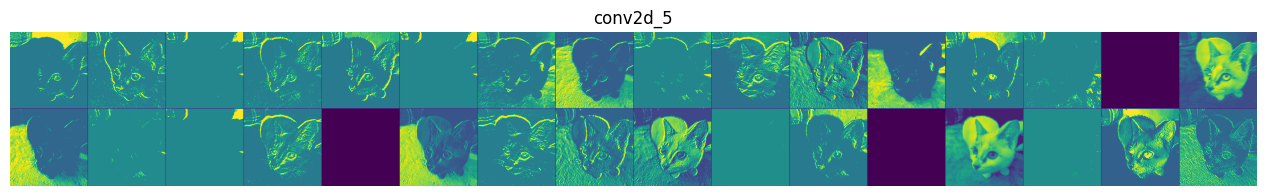

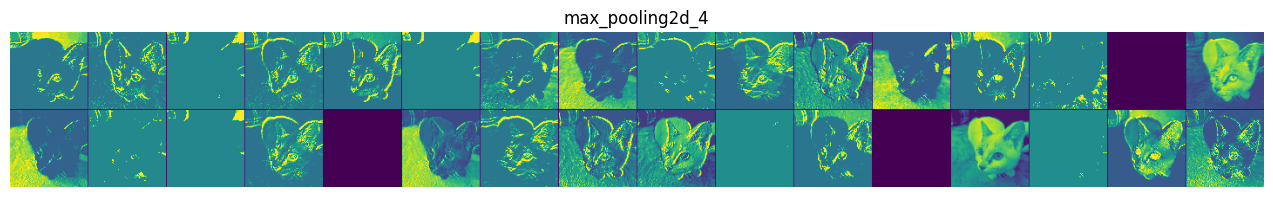

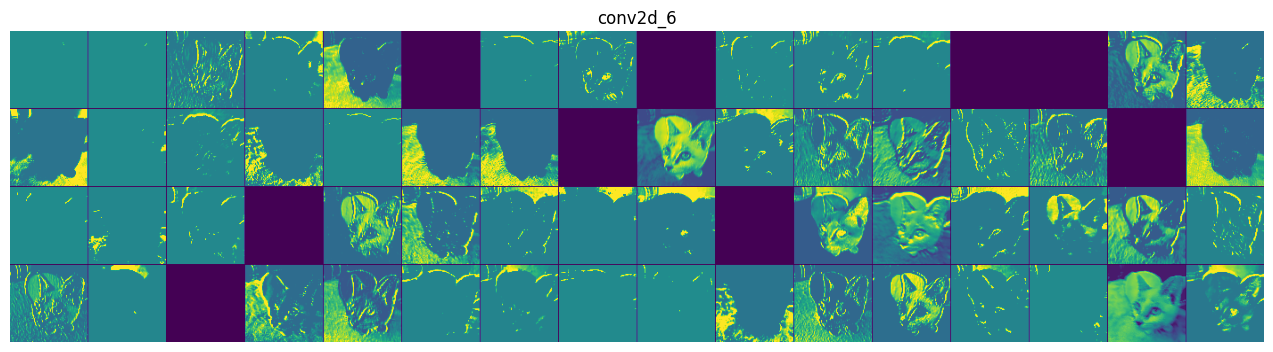

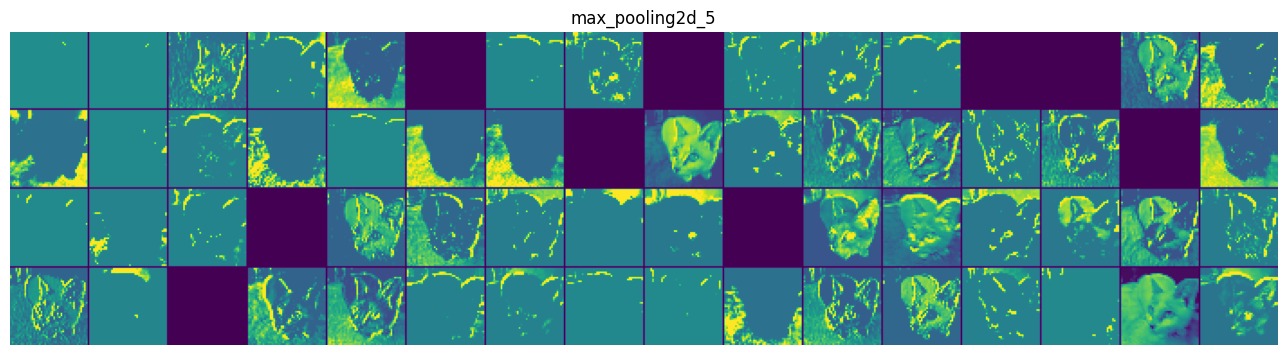

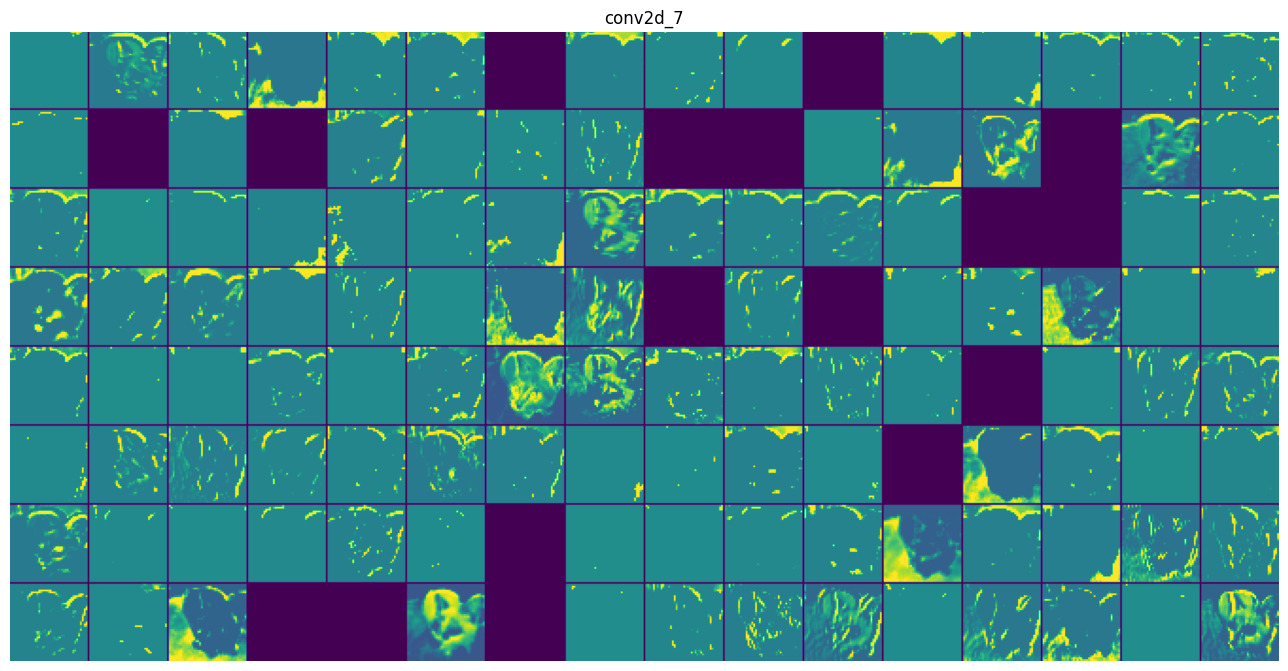

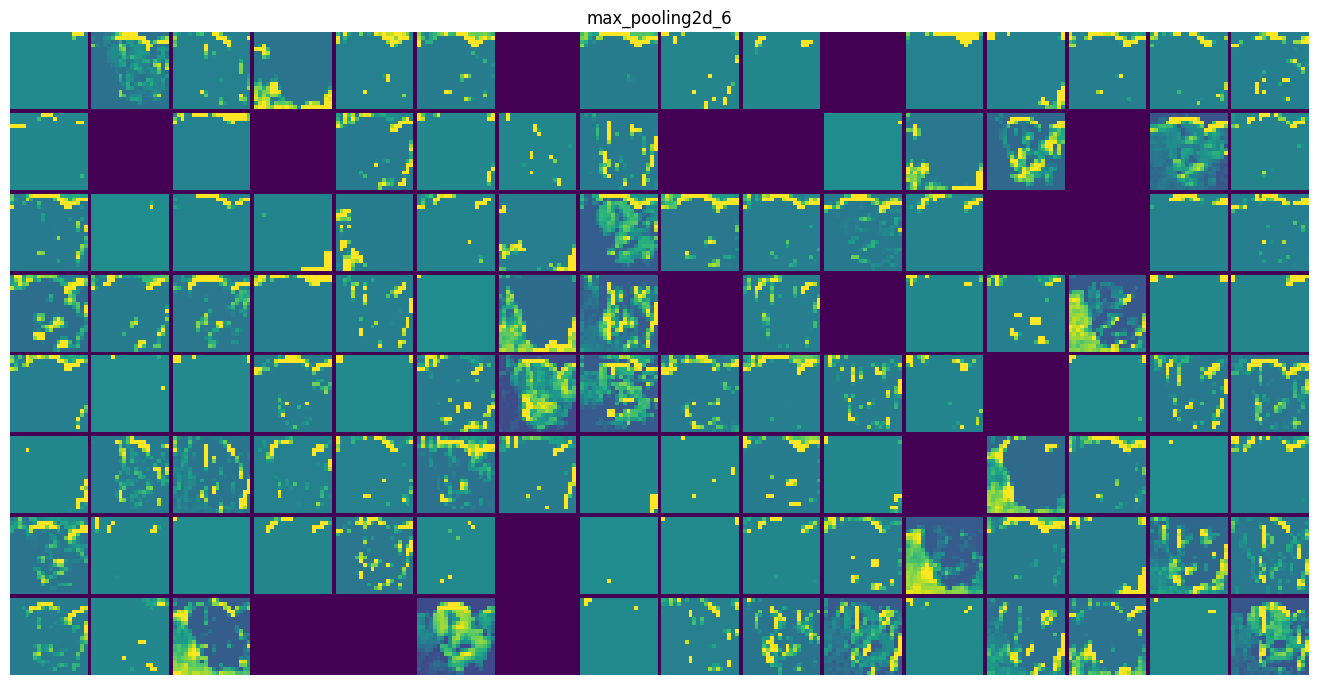

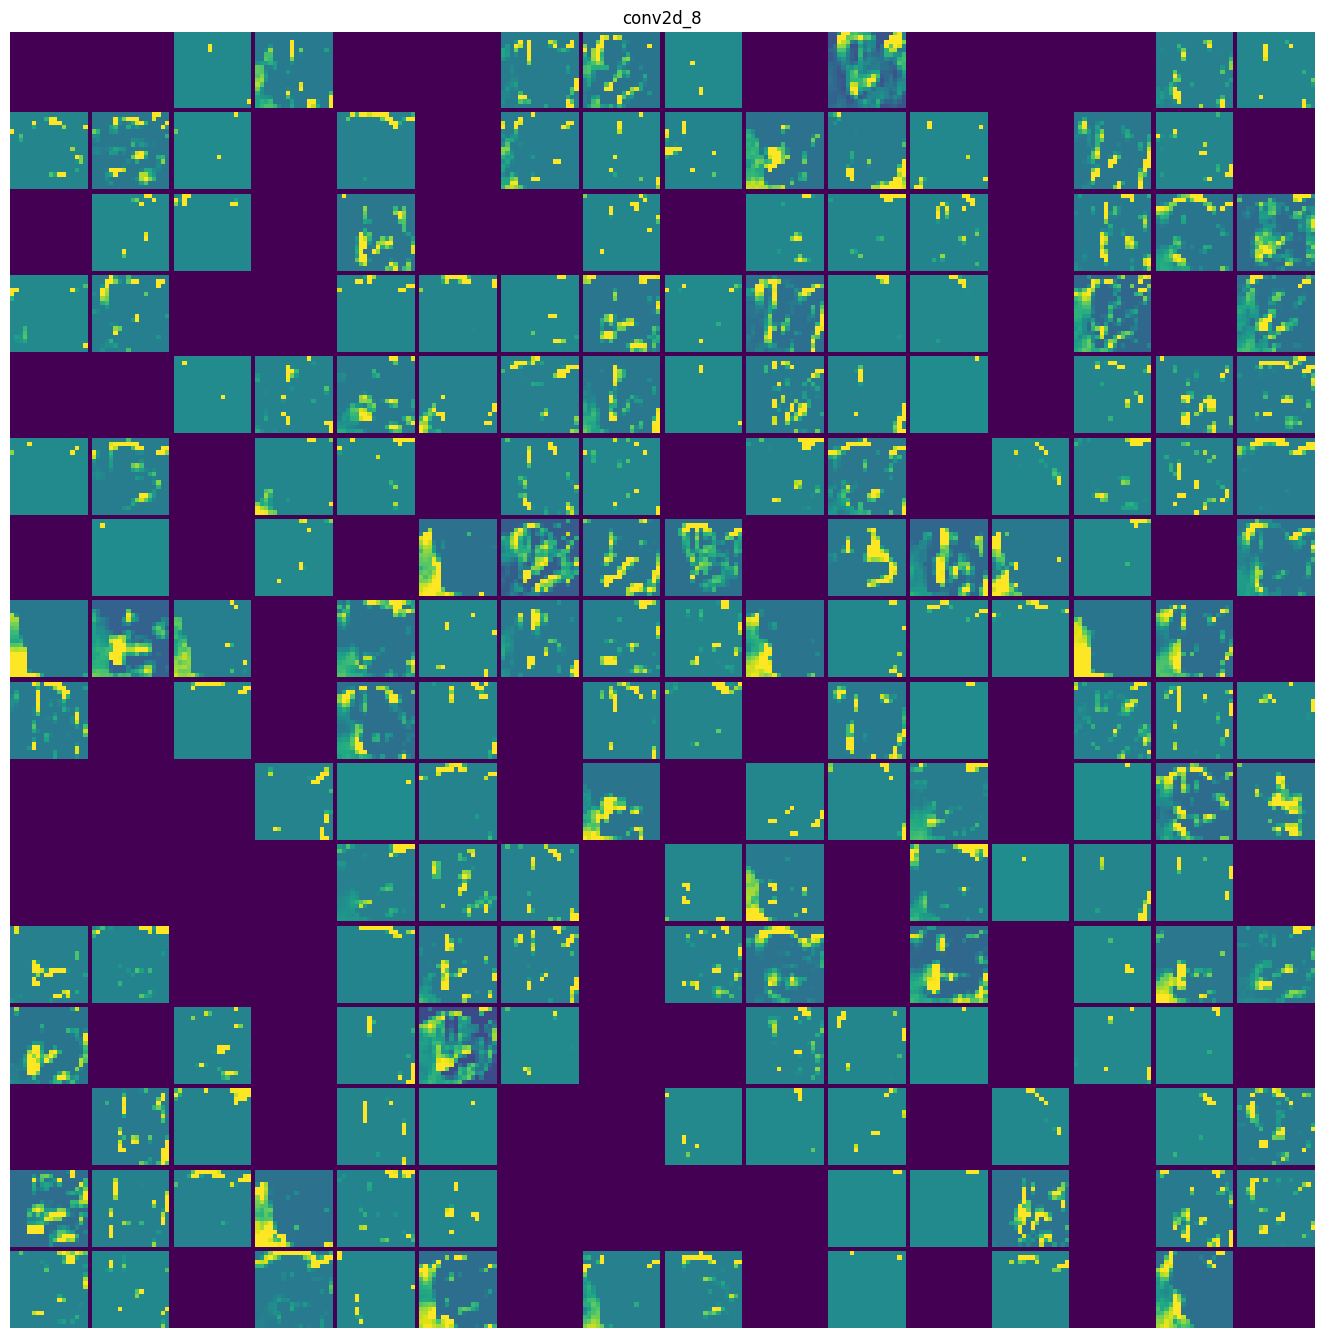

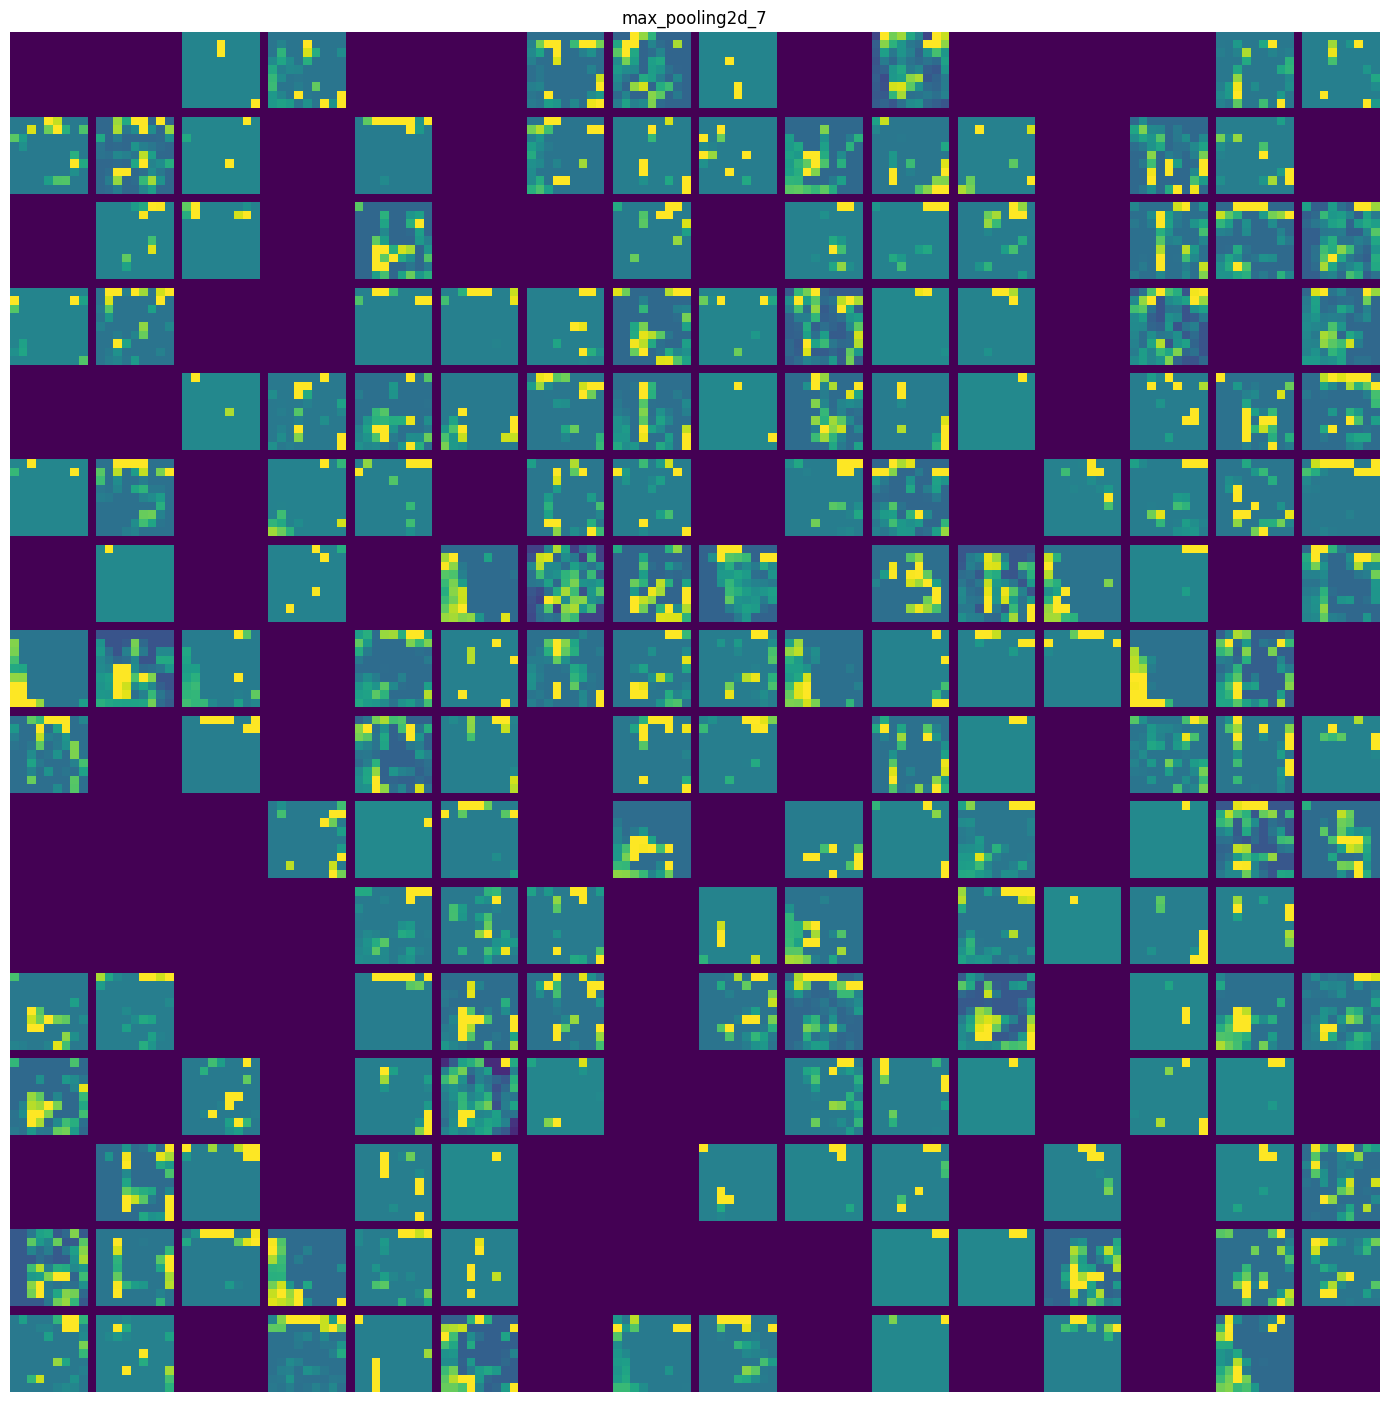

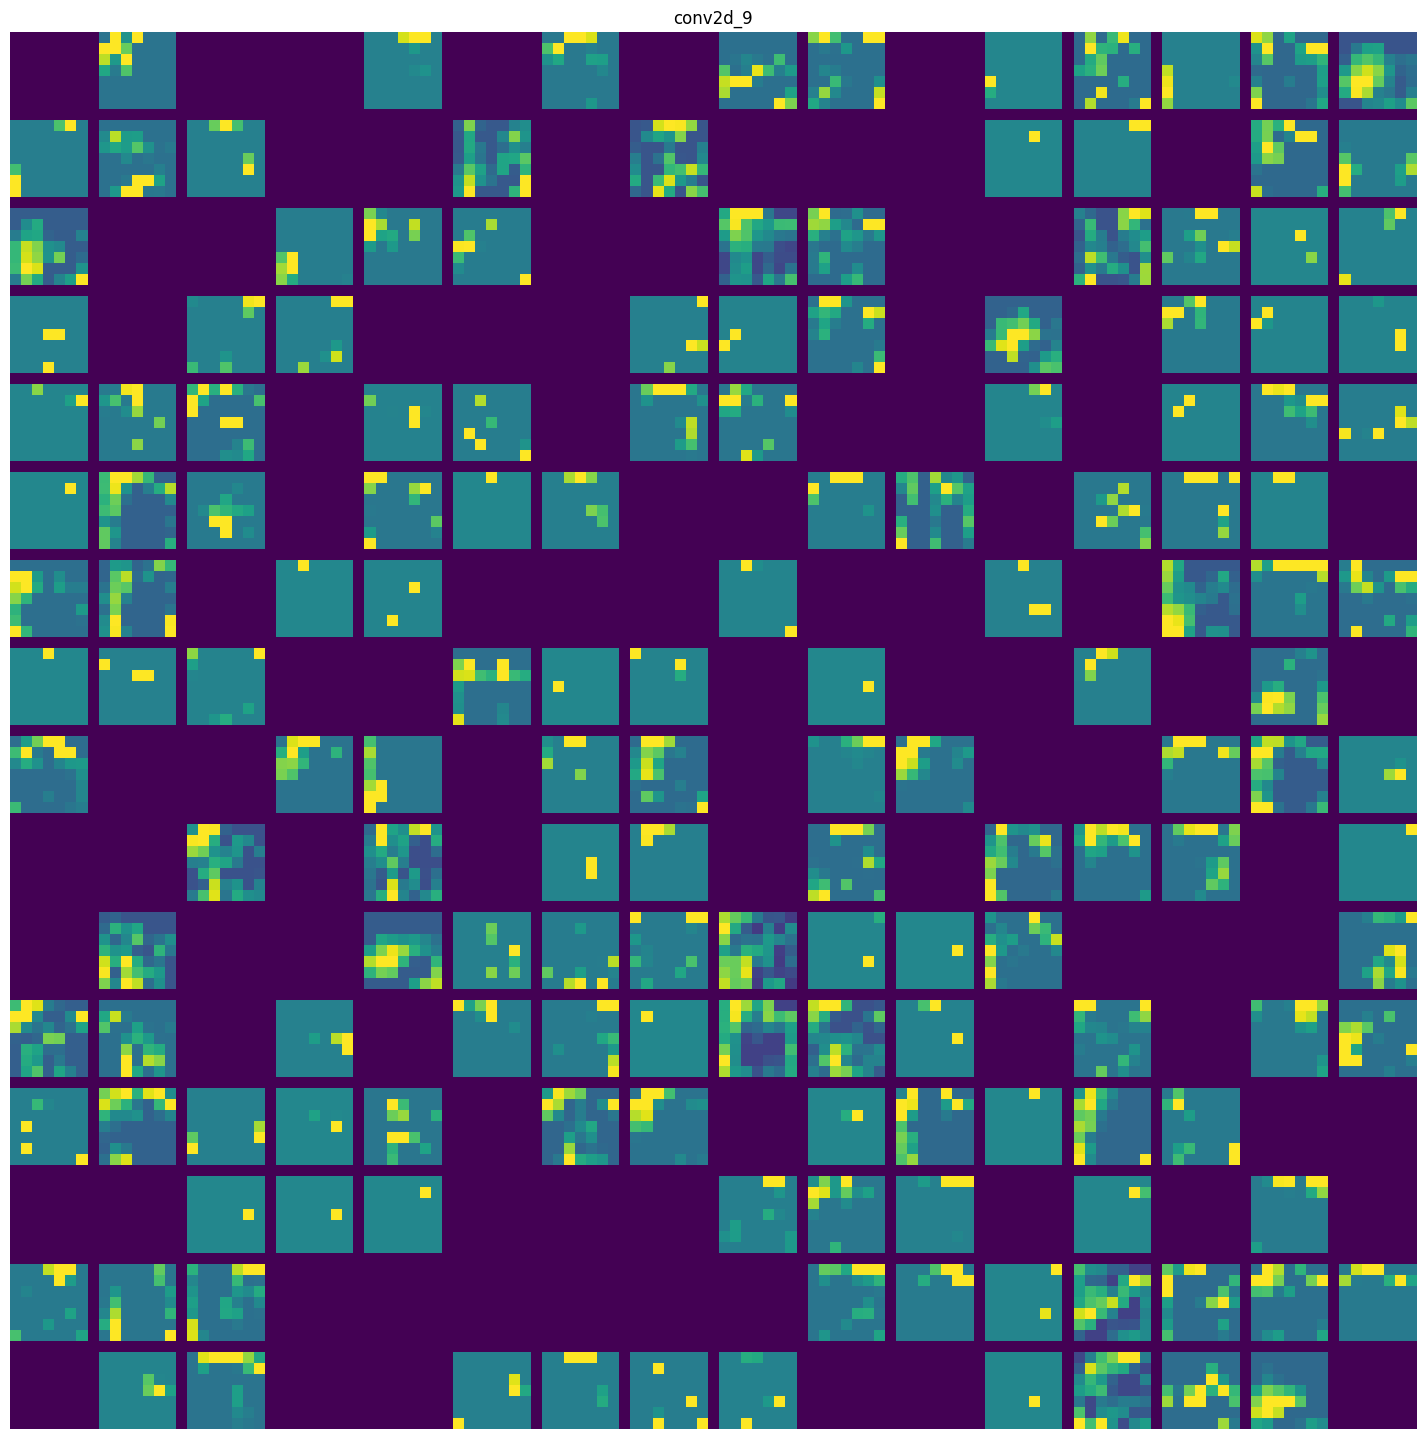

In [ ]:
images_per_row = 16
# Iterate over the activations (and the names of the corresponding layers).
for layer_name, layer_activation in zip(layer_names, activations):
    # The layer activation has shape (1, size, size, n_features)
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    # Prepare an empty grid for displaying all the channels in this activation.
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            # single channel (or feature)
            channel_image = layer_activation[0, :, :, channel_index].copy()
            # Normalize channel values within the [0, 255] range. All zero channels are kept at zero
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            # Place the channel matrix in the empty grid we prepared
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    # Display the grid for the layer
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

### Visualizing convnet filters

**Instantiating the Xception convolutional base**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# The classification layers are irrelevant for this use case,
# so we don’t include the top stage of the model.
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

**Printing the names of all convolutional layers in Xception**

In [ ]:
# The isinstance() function is used to check if a layer is an instance of a particular class
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d_4
block3_sepconv1
block3_sepconv2
conv2d_5
block4_sepconv1
block4_sepconv2
conv2d_6
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_7
block14_sepconv1
block14_sepconv2


**Creating a feature extractor model**

We need to extract model—**the Conv2D** and **SeparableConv2D layers**

The **SeparableConv2D layers** here are all named something like block6_sepconv1, block7_sepconv2, etc

In [ ]:
layer_name = "block3_sepconv1"
# the layer object to be extracted
layer = model.get_layer(name=layer_name)
# Use model.input and layer.output to create a model that, given an input image, returns the output of our target layer.
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

**Using the feature extractor**

In [ ]:
# Note that Xception requires inputs to be preprocessed via the "keras.applications.xception.preprocess_input" function
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [ ]:
# Use feature extractor model to define a function that returns a scalar value
# quantifying how much a given input image “activates” a given filter in the layer

import tensorflow as tf

# The loss function takes an image tensor and the index of the filter
def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    # Return the mean of the activation values for the filter
    return tf.reduce_mean(filter_activation)

# filter_activation:
#Note that we avoid border artifacts by only involving
#non-border pixels in the loss; we discard the first
#two pixels along the sides of the activation


'\nNote that we avoid border artifacts by only involving\nnon-border pixels in the loss; we discard the first\ntwo pixels along the sides of the activation\n'

**Loss maximization via stochastic gradient ascent**

In [ ]:
# use a @tf.function decorator to speed it up
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        # Explicitly watch the image tensor, since it isn’t a TensorFlow Variable
        # (only Variables are automatically watched in a gradient tape)
        tape.watch(image)
        # Compute the loss scalar, indicating how much the current image activates the filter
        loss = compute_loss(image, filter_index)
    # Compute the gradients of the loss with respect to the image.
    grads = tape.gradient(loss, image)
    # Apply the “gradient normalization trick.”
    grads = tf.math.l2_normalize(grads)
    # Move the image a little bit in a direction that activates our target filter more strongly.
    image += learning_rate * grads
    # Return the updated image so we can run the step function in a loop
    return image

**Function to generate filter visualizations**

In [ ]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    # Number of gradient ascent steps to apply
    iterations = 30
    # Amplitude of a single step
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,

        # Initialize an image tensor with random values
        # (the Xception model expects input values in the [0, 1] range,
        # so here we pick a range centered on 0.5).
        shape=(1, img_width, img_height, 3))
    # Repeatedly update the values of the image tensor so as to maximize our loss function.
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

**Utility function to convert a tensor into a valid image**

In [ ]:
def deprocess_image(image):
    # Normalize image values within the [0, 255] range
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    # Center crop to avoid border artifacts
    image = image[25:-25, 25:-25, :]
    return image

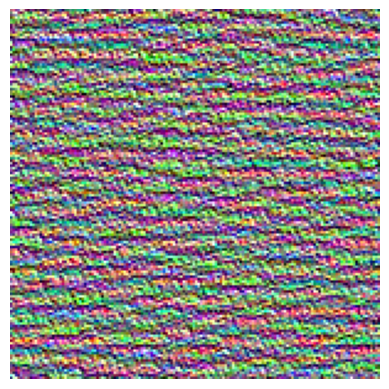

In [ ]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

**Generating a grid of all filter response patterns in a layer**

In [ ]:
all_images = []
# Generate and save visualizations for the first 64 filters in the layer
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

# Prepare a blank canvas for us to paste filter visualizations on
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with the saved filters
for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

# Save the canvas to disk
keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing filter 47
Pr

### Visualizing heatmaps of class activation

A class activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to the class under consideration

**Loading the Xception network with pretrained weights**

In [ ]:
# checkpoint
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
model = keras.applications.xception.Xception(weights="imagenet")

91884032/91884032 [==============================] - 1s 0us/step


**Preprocessing an input image for Xception**

In [ ]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    # Return a Python Imaging Library (PIL) image of size 299 × 299.
    img = keras.utils.load_img(img_path, target_size=target_size)
    # Return a float32 NumPy array of shape (299, 299, 3).
    array = keras.utils.img_to_array(img)
    # Add a dimension to transform the array into a batch of size (1, 299, 299, 3).
    array = np.expand_dims(array, axis=0)
    # Preprocess the batch (this does channel-wise color normalization).
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

733657/733657 [==============================] - 0s 0us/step


In [ ]:
preds = model.predict(img_array)
# Predict top three classes predicted for this image
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 0us/step
[('n02504458', 'African_elephant', 0.86993986), ('n01871265', 'tusker', 0.07695614), ('n02504013', 'Indian_elephant', 0.023541762)]


In [ ]:
# The entry in the prediction vector that was maximally activated is
# the one corresponding to the “African elephant” class, at index 386

np.argmax(preds[0])

386

**Setting up a model that returns the last convolutional output**

Set up the Grad-CAM process to visualize which parts of the image are the most African-elephant–like

In [ ]:
# First, we create a model that maps the input image to the activations of the last convolutional layer

last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

**Reapplying the classifier on top of the last convolutional output**

In [ ]:
# Second, we create a model that maps the activations of the last convolutional layer to the final class predictions

classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

**Retrieving the gradients of the top predicted class**

In [ ]:
# Then we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last convolution layer

import tensorflow as tf

with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Retrieve the activation channel corresponding to the top predicted class
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

# This is the gradient of the top predicted class with regard to the output feature map of the last convolutional layer
grads = tape.gradient(top_class_channel, last_conv_layer_output)

**Gradient pooling and channel-importance weighting**

In [ ]:
# Apply pooling and importance weighting to the gradient tensor to obtain our heatmap of class activation

# This is a vector where each entry is the mean intensity of the gradient for a given channel
# It quantifies the importance of each channel with regard to the top predicted class
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]

# Multiply each channel in the output of the last convolutional layer by “how important this channel is.”
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# The channel-wise mean of the resulting feature map is our heatmap of class activation
heatmap = np.mean(last_conv_layer_output, axis=-1)

**Heatmap post-processing**

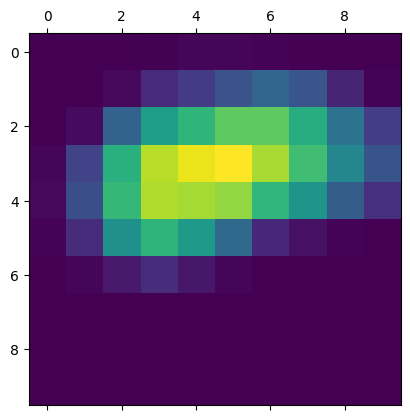

In [ ]:
# Normalize the heatmap between 0 and 1 for visualization purposes
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

**Superimposing the heatmap on the original picture**

In [ ]:
# Generate an image that superimposes the original image on the heatmap

import matplotlib.cm as cm

# load the orginal image
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

# rescale the heatmap to the range 0-255
heatmap = np.uint8(255 * heatmap)

# Use the "jet" colormap to recolorize the heatmap
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image that contains the recolorized heatmap
jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

# superimpose the heatmap and the original image, with the heatmap at 40% opacity
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

# save the superimpose image
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

<ipython-input-13-acee8f61cf4d>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


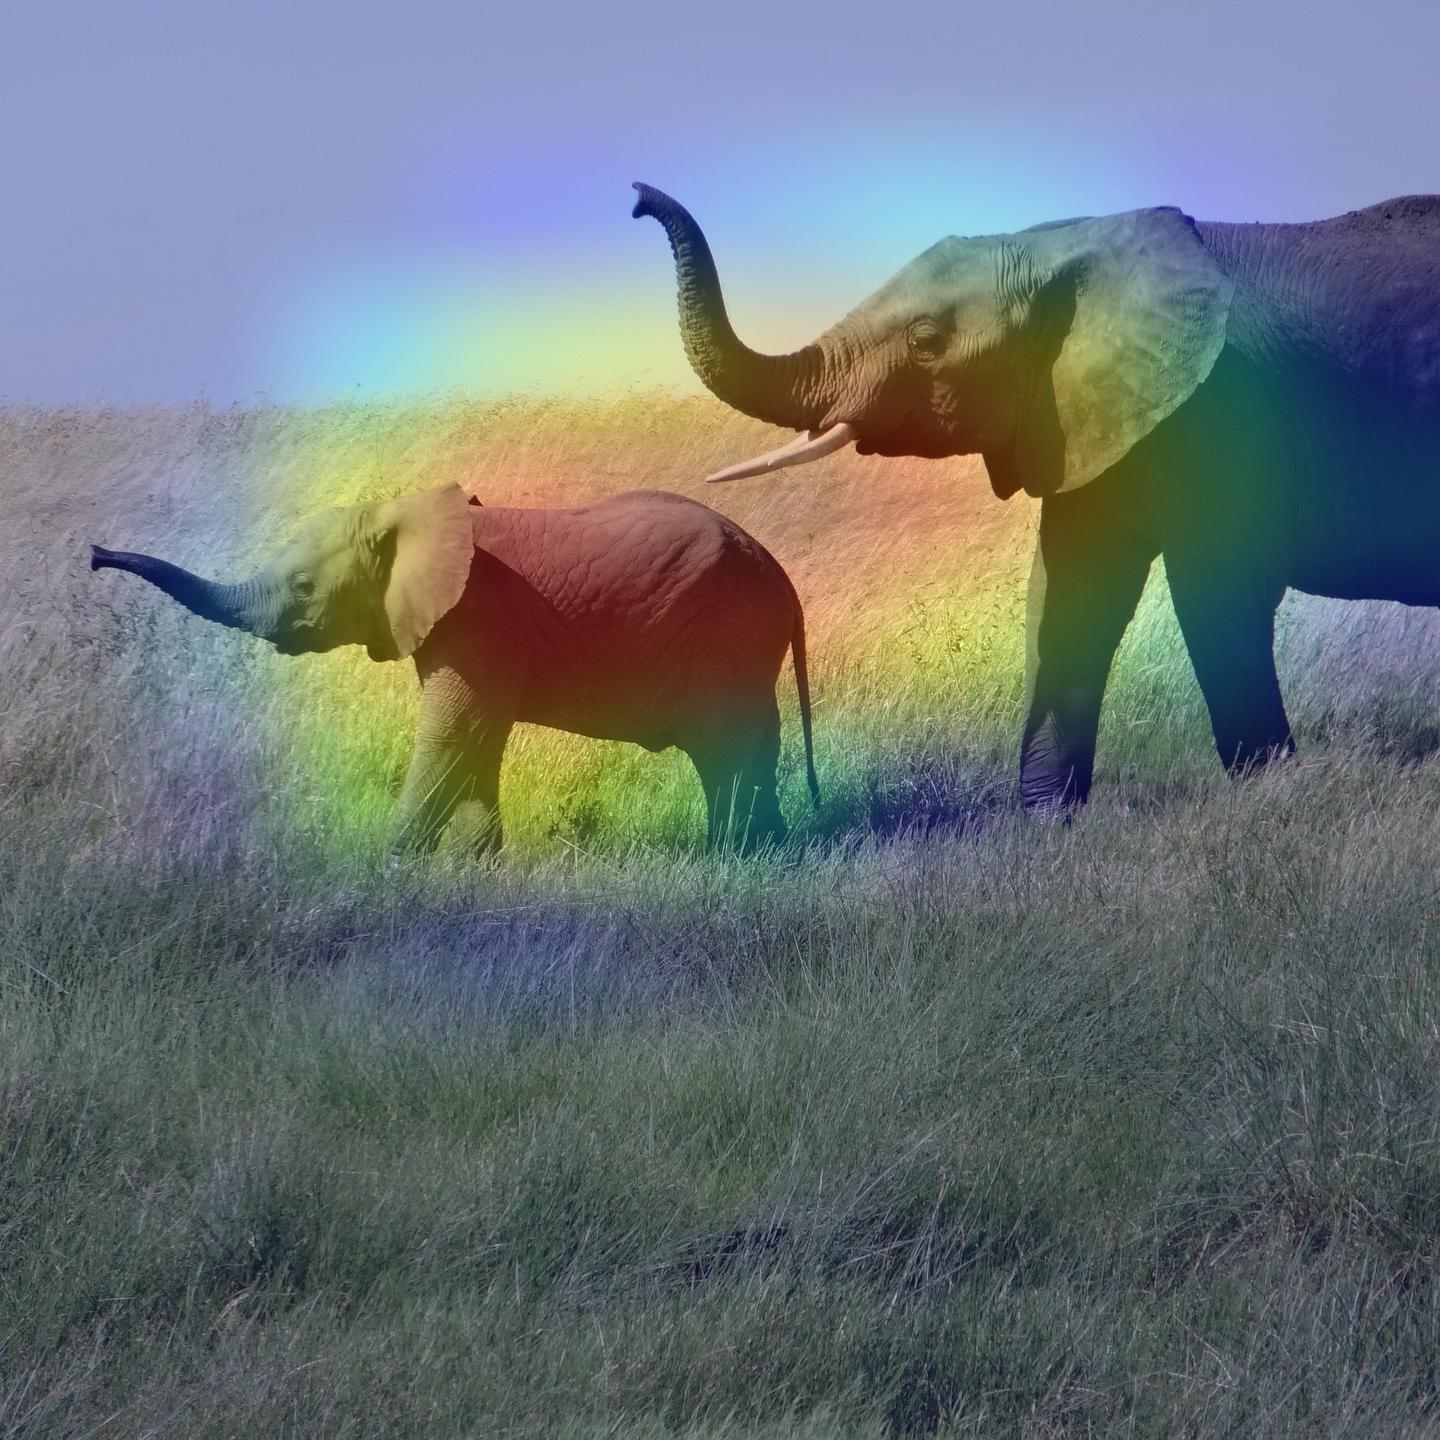

In [ ]:
img_trained = keras.utils.load_img("elephant_cam.jpg")
img_trained

The network probably learn by noticing the differentiation the ears of elephants and can tell the difference between elephant species from distinguished regions